### Model output evaluation notebook.
Inspired by Karel Vesely's apply_vad_segmenter.py script.

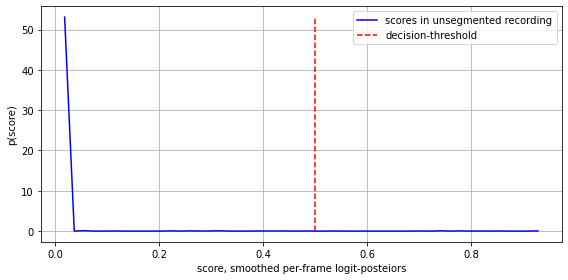

In [46]:
### import numpy as np
import torch
import matplotlib.pyplot as plt
import sys

from vad import Net

smooth_window = 31
speech_threshold = 0.5
min_segment_dur = 10
extra_speech_frames = 30

logit = np.random.random(2048)
N = smooth_window
s = np.cumsum(logit)
logit_smooth = np.hstack([ logit[:N//2], (s[N:] - s[:-N]) // N, logit[-N//2:] ])

f = plt.figure(figsize=(8,4));
# histogram
y,x = np.histogram(logit_smooth, bins=50, density=True)
plt.plot(x[1:],y,'b',label='scores in unsegmented recording');
plt.plot([speech_threshold,speech_threshold],[0,np.max(y)],'r--', label='decision-threshold');
plt.xlabel('score, smoothed per-frame logit-posteiors'); plt.ylabel('p(score)');
plt.grid(); plt.legend(); plt.tight_layout();

In [50]:
for i in range(1):
    # Get the segments,
    score = logit_smooth # will use smoothed logit-posterior scores,
    thr = speech_threshold # the decision threshold
    num_frames = logit_smooth.shape[0]
    #
    decisions = np.r_[False, score > thr, False] # score bigger than threshold is speech,
    speech_segs_raw = np.nonzero(decisions[1:] != decisions[:-1])[0].reshape(-1,2)
    if len(speech_segs_raw) == 0:
        continue
        
    # Frame extension,
    Next = extra_speech_frames
    speech_segs_ext = np.array(list(zip(speech_segs_raw[:,0] - Next, speech_segs_raw[:,1] + Next)))
    speech_segs_ext[speech_segs_ext<0] = 0
    speech_segs_ext[speech_segs_ext>=num_frames] = num_frames

    # Merge overlapping segments,
    decisions_ext = np.zeros(num_frames + 2)
    for (b,e) in speech_segs_ext : decisions_ext[b+1:e+1] = 1
    speech_segs_ext = np.nonzero(decisions_ext[1:] != decisions_ext[:-1])[0].reshape(-1,2)
    
    
    # Make sure no raw-segment is shorter than 0.10s,
    Tmin = min_segment_dur + 2*(Next if Next > 0 else 0)
    speech_segs = speech_segs_ext[(speech_segs_ext[:,1]-speech_segs_ext[:,0])>Tmin]
    if len(speech_segs) == 0: # no-speech-found! (all segments dropped, min duration)
        continue
        
    # Add to segments
    #segments.append(['%s!%07d-%07d %s %06.2f %06.2f' % (utt,beg,end,utt,beg/100.,end/100.) for beg,end in speech_segs])

        

[[   9   10]
 [  14   15]
 [2034 2035]
 [2036 2037]
 [2038 2039]
 [2040 2043]
 [2044 2047]]
